In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys, os
sys.path.append('..')
import urban8k_helpers as helpers

sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import evaluation, audio_utils, cnn_utils

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


In [3]:
base_path = '/media/michael/Seagate/urban8k/'
loadpath = base_path + 'splits_128/split' + str(3) + '.pkl'
data, num_classes = helpers.load_data(
    loadpath, small_dataset=False, do_median_normalise=True)

slice_width = 128

Loading data
There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]
train_X 6817 train_y 6817 val_y 990 val_X 990 test_y 925 test_X 925


In [4]:
def form_slices_validation_set(data):

    val_X = [helpers.tile_pad(xx, slice_width) for xx in data['val_X']]
    val_X = [audio_utils.median_normalise(xx) for xx in val_X]

    val_y = np.hstack(data['val_y'])
    val_X = cnn_utils.form_correct_shape_array(val_X)

    print "validation set is of size ", val_X.shape, val_y.shape

    return val_X, val_y


In [5]:
val_X, val_y = form_slices_validation_set(data)

validation set is of size  (990, 1, 128, 128) (990,)


In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):

    assert len(inputs) == len(targets)

    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)

    print len(inputs) - batchsize
    for start_idx in range(0, len(inputs), batchsize):
        
        end_idx = min(start_idx + batchsize, len(inputs))

        if shuffle:
            excerpt = indices[start_idx:end_idx]
        else:
            excerpt = np.arange(start_idx, end_idx)
            print "Min max", excerpt.min(), excerpt.max(), inputs.shape

        # take a single random slice from each of the training examples
        these_spectrograms = [inputs[xx] for xx in excerpt]
        Xs = [helpers.tile_pad(x[0], slice_width) for x in these_spectrograms]
        Xs_to_return = cnn_utils.form_correct_shape_array(Xs)
        yield Xs_to_return, targets[excerpt]

TypeError: unhashable type: 'numpy.ndarray'

In [24]:
total_x = 0
used = {}
ys = []
count = 0
for xx, yy in iterate_minibatches(val_X, val_y, 100):
    print xx.shape
    total_x += xx.shape[0]
    for x in xx:
        used[tuple(map(tuple, x[0]))] = 1
    ys.append(yy)
    
print total_x, val_X.shape[0], len(used.keys())

890
Min max 0 99 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 100 199 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 200 299 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 300 399 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 400 499 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 500 599 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 600 699 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 700 799 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 800 899 (990, 1, 128, 128)
(100, 1, 128, 128)
Min max 900 989 (990, 1, 128, 128)
(90, 1, 128, 128)
990 990 990


In [26]:
Ys = np.hstack(ys)
print Ys.shape
print np.bincount(Ys)

(990,)
[100  59 100 100 100 107  38 120 166 100]


In [42]:
augment_data = False

def generate_balanced_minibatches_multiclass(
        inputs, targets, items_per_minibatch, shuffle=True):

    assert len(inputs) == len(targets)

    all_targets = np.unique(targets)

    idxs = {this_targ: np.where(targets==this_targ)[0]
            for this_targ in all_targets}

    if shuffle:
        for key in idxs.keys():
            np.random.shuffle(idxs[key])

    num_per_class_per_minibatch = items_per_minibatch / len(all_targets)

    # find the largest class - this will define the epoch size
    examples_in_epoch = max([len(x) for _, x in idxs.iteritems()])

    # in each batch, new data from largest class is provided
    # data from other class is reused once it runs out
    for start_idx in range(0,
                           examples_in_epoch,
                           num_per_class_per_minibatch):
        
        end_idx = min(start_idx + num_per_class_per_minibatch, len(inputs))

        # get indices for each of the excerpts, wrapping back to the beginning...
        excerpts = []
        for target, this_target_idxs in idxs.iteritems():
            these_idxs = np.take(this_target_idxs,
                np.arange(start_idx, end_idx), mode='wrap')
            excerpts.append(these_idxs)

        # for each of the training indices for this minibatch, extract and
        # pre-process a training instance
        training_images = []
        full_idxs = np.hstack(excerpts)

        for idx in full_idxs:
            this_image = inputs[idx]
            this_image = helpers.tile_pad(this_image, slice_width)
            if augment_data:
                this_image = helpers.augment_slice(this_image, **augment_options)
            training_images.append(this_image)

        yield (cnn_utils.form_correct_shape_array(training_images), targets[full_idxs])


In [48]:
total_x = 0
used = {}
ys = []
count = 0
for xx, yy in generate_balanced_minibatches_multiclass(np.squeeze(val_X[:323]), val_y[:323], 10):
    total_x += xx.shape[0]
    for x in xx:
        used[tuple(map(tuple, x[0]))] = 1
    ys.append(yy)
    
print total_x, val_X.shape[0], len(used.keys())
print np.bincount(np.hstack(ys))

740 990 323
[74 74 74 74 74 74 74 74 74 74]


In [49]:
print np.bincount(val_y)
print val_X.shape

[100  59 100 100 100 107  38 120 166 100]
(990, 1, 128, 128)


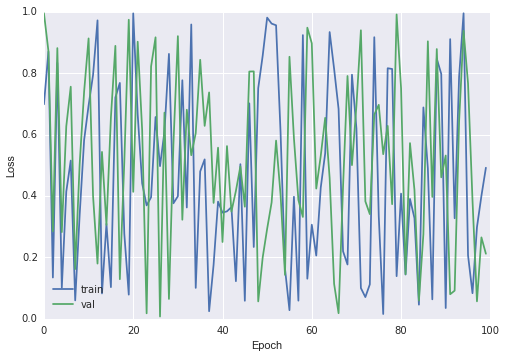

In [55]:
train = np.random.rand(100)
val = np.random.rand(100)

import seaborn as sns
plt.plot(train, label='train')
plt.plot(val, label='val')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')